# Training a simple CNN model in `keras` (>3.0) for Tornado Detection

This notebook steps through how to train a simple CNN model using a subset of TorNet.

This will not produce a model with any skill, but simply provides a working end-to-end example of how to set up a data loader, build, and fit a model


In [1]:
import os
os.environ['KERAS_BACKEND']='tensorflow' # set to 'tensorflow', 'torch' or 'jax' (installs required)

In [2]:
import sys
# Uncomment if tornet isn't installed in your environment or in your path already
sys.path.append('../')  

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras



In [3]:
from tornet.data.tf.loader import create_tf_dataset 
from tornet.data.constants import ALL_VARIABLES
import tornet.models.keras as k 

In [4]:
# keras accepts most data loaders (tensorflow, torch).
# A pure keras data loader, with necessary preprocessing steps for the cnn baseline, is provided
from tornet.data.keras.loader import KerasDataLoader
data_root = "C:/Users/mjhig/tornet_2013"
ds = KerasDataLoader(data_root=data_root,
                     data_type='train',
                     years=[2013,2014,2015,2016,2017,2018],
                     batch_size = 128, 
                     workers = 4,
                     use_multiprocessing = True)


import tensorflow as tf
from tensorflow.keras.layers import Layer, Conv2D, ReLU

class CoordConv2D(Layer):
    """
    CoordConv2D layer for working with polar data in Keras.

    This layer takes a tuple of inputs (image tensor, image coordinates),
    where:
        - image tensor: [batch, height, width, in_image_channels]
        - image coordinates: [batch, height, width, in_coord_channels]

    Returns:
        A tuple containing:
        - CoordConv output after applying convolution + activation.
        - (Possibly downsampled) coordinate tensor.
    """
    def __init__(self, in_coord_channels, out_channels, kernel_size, 
                 padding='same', stride=1, activation='relu', **kwargs):
        super(CoordConv2D, self).__init__(**kwargs)
        self.in_coord_channels = in_coord_channels
        self.stride = stride
        self.padding = padding
        self.kernel_size = kernel_size
        self.activation = activation

        # Define convolutional layer
        self.conv = Conv2D(
            filters=out_channels,
            kernel_size=kernel_size,
            strides=stride,
            padding=padding,
            use_bias=True
        )

        # Define activation function
        if activation is None:
            self.conv_activation = None
        elif activation == 'relu':
            self.conv_activation = ReLU()
        else:
            raise NotImplementedError(f'Activation {activation} not implemented')

    def call(self, inputs, training=False):
        """
        Forward pass.

        inputs: tuple (image_tensor, coords_tensor)
        - image_tensor: shape [batch, height, width, in_image_channels]
        - coords_tensor: shape [batch, height, width, in_coord_channels]

        Returns:
        - Convolution output with activation applied
        - (Possibly downsampled) coordinate tensor
        """
        x, coords = inputs
        x = tf.concat([x, coords], axis=-1)  # Concatenate along channel axis
        x = self.conv(x)

        # Apply activation function
        if self.conv_activation:
            x = self.conv_activation(x)

        # Downsample coordinates if stride > 1
        if self.padding == 'same' and self.stride > 1:
            coords = coords[:, ::self.stride, ::self.stride, :]
        elif self.padding == 'valid':
            # Adjust coordinates for valid padding
            i0 = self.kernel_size[0] // 2
            if i0 > 0:
                coords = coords[:, i0:-i0:self.stride, i0:-i0:self.stride, :]
            else:
                coords = coords[:, ::self.stride, ::self.stride, :]

        return x, coords

    def get_config(self):
        config = super().get_config()
        config.update({
            "in_coord_channels": self.in_coord_channels,
            "stride": self.stride,
            "padding": self.padding,
            "kernel_size": self.kernel_size,
            "activation": self.activation
        })
        return config


In [18]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (
    Concatenate,
    GlobalMaxPool2D,
    Normalization,
    Conv2D,
    MaxPooling2D,
    Dense,
    Dropout,
)
from tornet.models.keras.layers import FillNaNs  # Custom layer for handling NaNs
from tornet.data.constants import CHANNEL_MIN_MAX  # Min/max values for normalization
from coord import CoordinateChannel1D, CoordinateChannel2D, CoordinateChannel3D  # Custom layer for adding coordinate channels

# -------------------------------------------------------------------
# NOTE: Make sure ALL_VARIABLES is defined earlier in your code.
# For example:
# ALL_VARIABLES = ['reflectivity', 'velocity', 'spectrum_width']  (etc.)
# -------------------------------------------------------------------
input_vars = ALL_VARIABLES  # List of radar variables used as inputs (excluding 'coordinates')

# -------------------
# Define Model Inputs
# -------------------
# Create one Input per radar variable.
inputs = {v: keras.Input(shape=(120, 240, 2), name=v) for v in input_vars}

# -------------------
# Normalize Inputs
# -------------------
# Create a Normalization layer for each input variable using its min/max.
norm_layers = []
for v in input_vars:
    min_max = np.array(CHANNEL_MIN_MAX[v])  # [min, max]

    # Approximate [-1,1] scaling.
    # Compute the variance term (assuming a linear scaling) and offset.
    var = ((min_max[1] - min_max[0]) / 2) ** 2
    var = np.array([var, var])  # shape: (2,)
    offset = (min_max[0] + min_max[1]) / 2
    offset = np.array([offset, offset])  # shape: (2,)
    
    norm_layers.append(
        Normalization(mean=offset, variance=var, name=f'Normalized_{v}')
    )

# (Re)define inputs if necessary (this is the same as before)
inputs = {v: keras.Input(shape=(120, 240, 2), name=v) for v in input_vars}

# -------------------
# Concatenate Normalized Inputs
# -------------------
# Apply the normalization layer for each input variable, then concatenate them along the channel axis.
x = Concatenate(axis=-1, name='Concatenate1')(
    [l(inputs[v]) for l, v in zip(norm_layers, input_vars)]
)

# -------------------
# Replace NaNs
# -------------------
x = FillNaNs(fill_val=-3, name='ReplaceNan')(x)

# -------------------
# CoordConv Layers
# -------------------
# Add coordinate channels to the input tensor. You can optionally pass arguments (e.g., with_r=True)
# if you want to include radial coordinates.
x = CoordinateChannel2D(name='CoordConvChannels')(x)

# -------------------
# Convolutional Blocks
# -------------------
# First block: two Conv2D layers with 32 filters each, followed by MaxPooling.
x = Conv2D(32, (3, 3), activation='relu', padding='same', name='Conv2D_1')(x)
x = Dropout(0.1, name='Dropout_1')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', name='Conv2D_2')(x)
x = Dropout(0.1, name='Dropout_2')(x)
x = MaxPooling2D(pool_size=(2, 2), name='MaxPool_1')(x)

# Second block: two Conv2D layers with 64 filters each, followed by MaxPooling.
x = Dropout(0.1, name='Dropout_3')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='Conv2D_3')(x)
x = Dropout(0.1, name='Dropout_4')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='Conv2D_4')(x)
x = MaxPooling2D(pool_size=(2, 2), name='MaxPool_2')(x)

# Third block: two Conv2D layers with 128 filters each.
x = Dropout(0.1, name='Dropout_5')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='Conv2D_5')(x)
x = Dropout(0.1, name='Dropout_6')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='Conv2D_6')(x)

# -------------------
# Global Pooling and Dense Layers
# -------------------
# Reduce the spatial dimensions to a fixed-length vector.
x = GlobalMaxPool2D(name='GlobalMaxPool')(x)

# Add a fully-connected layer for learning higher-level features.
x = Dense(256, activation='relu', name='Dense_1')(x)
x = Dropout(0.5, name='Dropout')(x)

# Final output layer.
# Change the number of neurons and activation as needed (e.g., for multiclass classification or regression).
output = Dense(1, activation='sigmoid', name='Output')(x)

# -------------------
# Build and Compile Model
# -------------------
model = keras.Model(inputs=list(inputs.values()), outputs=output, name='TornadoNet')

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print a model summary
model.summary()


Model: "TornadoNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ DBZ (InputLayer)    │ (None, 120, 240,  │          0 │ -                 │
│                     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ VEL (InputLayer)    │ (None, 120, 240,  │          0 │ -                 │
│                     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ KDP (InputLayer)    │ (None, 120, 240,  │          0 │ -                 │
│                     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ RHOHV (InputLayer)  │ (None, 120, 240,  │          0 │ -                 │
│                     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ZDR (InputLayer)    │ (None, 120, 240,  │          0 │ -                 │
│                     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ WIDTH (InputLayer)  │ (None, 120, 240,  │          0 │ -                 │
│                     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Normalized_DBZ      │ (None, 120, 240,  │          0 │ DBZ[0][0]         │
│ (Normalization)     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Normalized_VEL      │ (None, 120, 240,  │          0 │ VEL[0][0]         │
│ (Normalization)     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Normalized_KDP      │ (None, 120, 240,  │          0 │ KDP[0][0]         │
│ (Normalization)     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Normalized_RHOHV    │ (None, 120, 240,  │          0 │ RHOHV[0][0]       │
│ (Normalization)     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Normalized_ZDR      │ (None, 120, 240,  │          0 │ ZDR[0][0]         │
│ (Normalization)     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Normalized_WIDTH    │ (None, 120, 240,  │          0 │ WIDTH[0][0]       │
│ (Normalization)     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Concatenate1        │ (None, 120, 240,  │          0 │ Normalized_DBZ[0… │
│ (Concatenate)       │ 12)               │            │ Normalized_VEL[0… │
│                     │                   │            │ Normalized_KDP[0… │
│                     │                   │            │ Normalized_RHOHV… │
│                     │                   │            │ Normalized_ZDR[0… │
│                     │                   │            │ Normalized_WIDTH… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ isnan_5 (Isnan)     │ (None, 120, 240,  │          0 │ Concatenate1[0][… │
│                     │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ where_5 (Where)     │ (None, 120, 240,  │          0 │ isnan_5[0][0],    │
│                     │ 12)               │            │ Concatenate1[0][… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 323,457 (1.23 MB)

 Trainable params: 323,457 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train
from tensorflow.keras.metrics import AUC, Precision, Recall,BinaryAccuracy
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam,AdamW
from keras.callbacks import EarlyStopping
# steps_per_epoch=10 for demo purposes
early_stopping = EarlyStopping(
    monitor='pr_auc',
    patience=2,
    mode='max',
    restore_best_weights=True
)
loss=BinaryCrossentropy()
opt= AdamW(learning_rate=0.001)
metrics = [AUC(from_logits=True,name='AUC'),
          AUC(curve='PR',name='PR_AUC'),
        BinaryAccuracy(name='BinaryAccuracy'), 
           ]
# Recompile the model with additional metrics
model.compile(
    optimizer=opt,
    loss=loss,
    metrics=[
        AUC(curve='PR', name='pr_auc'),
        AUC(name='AUC'),
        BinaryAccuracy(name='BinaryAccuracy')
    ])

# Train the model
history = model.fit(ds, epochs=20, steps_per_epoch=10, callbacks=[early_stopping])


Epoch 1/20


c:\Users\mjhig\anaconda3\envs\tornet-torch\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['DBZ', 'VEL', 'KDP', 'RHOHV', 'ZDR', 'WIDTH']. Received: the structure of inputs={'DBZ': '*', 'VEL': '*', 'KDP': '*', 'RHOHV': '*', 'ZDR': '*', 'WIDTH': '*', 'range_folded_mask': '*', 'label': '*', 'category': '*', 'event_id': '*', 'ef_number': '*', 'az_lower': '*', 'az_upper': '*', 'rng_lower': '*', 'rng_upper': '*', 'time': '*', 'tornado_start_time': '*', 'tornado_end_time': '*', 'coordinates': '*'}
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 137s 11s/step - AUC: 0.4855 - BinaryAccuracy: 0.7892 - loss: 1.1300 - pr_auc: 0.0765
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 88s 9s/step - AUC: 0.4010 - BinaryAccuracy: 0.9308 - loss: 0.3571 - pr_auc: 0.0552
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 148s 16s/step - AUC: 0.3015 - BinaryAccuracy: 0.9186 - loss: 0.3934 - pr_auc: 0.0551


In [10]:
model.save('model_w_coordconv.keras')

<Axes: >

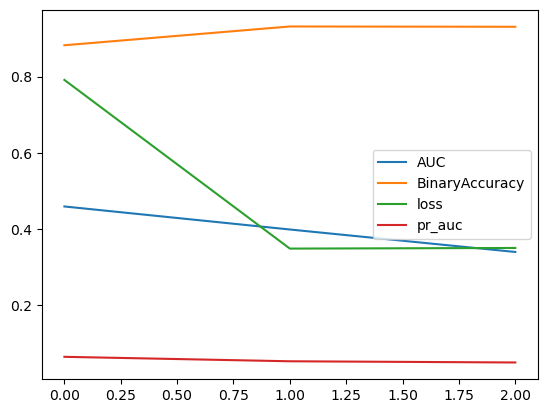

In [20]:
history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5. You can change this to get a different view.
history_df.plot()

In [ ]:
# Build a test set
ds_test = KerasDataLoader(data_root=data_root,
                         data_type='test',
                         years=[2018,2019],
                         batch_size = 8, 
                         workers = 4,
                         use_multiprocessing = True)


In [ ]:
# Evaluate
import tornet.metrics.keras.metrics as km
metrics = [keras.metrics.AUC(from_logits=True,name='AUC'),
           km.BinaryAccuracy(from_logits=True,name='BinaryAccuracy'), 
           ]
model.compile(loss=loss,metrics=metrics)

# steps=10 for demo purposes
model.evaluate(ds_test,steps=10)
